In [1]:
import pandas as pd
from evaluation_utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set_palette(('#193063', '#f0b660', '#56a4ba', '#f28157', '#6079B3', '#7d1b2a'))


In [2]:
df_sus_complaints = pd.read_parquet('data_processing/train_models/output/sustained_complaints/observations_with_predictions.parquet')
df_sus_complaints['pred_year'] = df_sus_complaints['observation_date'].dt.year

df_lawsuits = pd.read_parquet('data_processing/train_models/output/expensive_lawsuit/observations_with_predictions.parquet')
df_lawsuits['pred_year'] = df_lawsuits['observation_date'].dt.year


ml_col = 'phat'
rbc_col = 'past_two_years.complaints.total'
rbl_col = 'past_two_years.lawsuits.total'
complaint_outcome = 'future_two_years.complaints.disposition_substantiated'
lawsuit_outcome = 'future_two_years.lawsuits.high_payout_suit'

# C1: Summary stats of dataset size

### Number of observations


In [3]:
df_sus_complaints.pred_year.value_counts()

2019    35697
2018    35507
2017    35381
2016    34767
2015    33942
Name: pred_year, dtype: int64

In [4]:
df_sus_complaints.shape

(175294, 138)

### Total features

In [5]:
df_sus_complaints.filter(like='past').shape

(175294, 117)

### Base rates

In [6]:
base_rates = calc_base_rate_across_years(df_sus_complaints, complaint_outcome)
base_rates.rename(columns={'base_rate':"Percentage of officers with sustained complaint in next two years"})                                                                         

,Percentage of officers with sustained complaint in next two years
pred_year,
2015,0.028342
2016,0.023269
2017,0.024448
2018,0.033346
2019,0.045998


In [7]:
base_rates = calc_base_rate_across_years(df_lawsuits, lawsuit_outcome)
base_rates.rename(columns={'base_rate':"Percentage of officers with expensive lawsuit in next two years"})                                                                         

,Percentage of officers with expensive lawsuit in next two years
pred_year,
2015,0.029639
2016,0.021227
2017,0.019417
2018,0.016983
2019,0.011598


### 

# C2: Performance of machine learning models

In [8]:

recalls = [ (100*q,calc_recall(df_sus_complaints, 'phat',complaint_outcome,q)) for q in np.linspace(.5,1,51)]
sus_recall_df = pd.DataFrame(recalls,columns=['Risk Percentile','Recall'])
sus_recall_df['Outcome'] = 'Sustained Complaints'



recalls = [ (100*q,calc_recall(df_lawsuits, 'phat',lawsuit_outcome,q)) for q in np.linspace(.5,1,51)]
lawsuit_recall_df = pd.DataFrame(recalls,columns=['Risk Percentile','Recall'])
lawsuit_recall_df['Outcome'] = 'Expensive Lawsuits'

recall_df = pd.concat([sus_recall_df,lawsuit_recall_df],ignore_index=True)

In [9]:
calc_recall(df_lawsuits, 'phat','future_two_years.lawsuits.officer_payout',.95,indicator=False)

0.2781098268957099

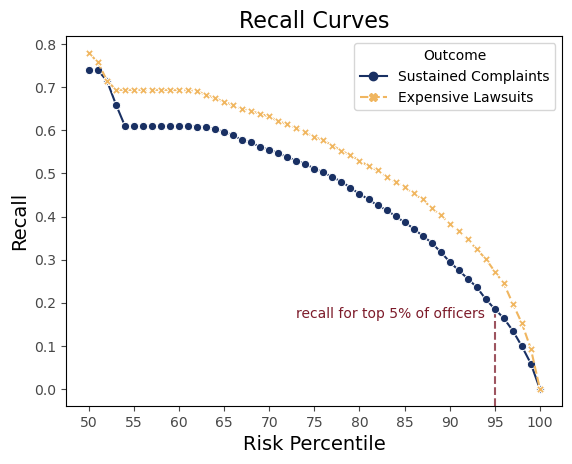

In [10]:
with plt.rc_context({
                     'xtick.color': '.28',
                     'ytick.color': '.28',
                     'axes.grid.axis': 'y',
                     'axes.titlesize': 16,
                     'axes.labelsize': 14,
                     'xtick.bottom': True,
                    }):
    figure = plt.figure()
    plt.axvline(
        x=95, 
        ymin=0, 
        ymax=recall_df[recall_df['Risk Percentile'] == 95]['Recall'].max(), 
        color='#7d1b2a', 
        alpha=.75,
        linestyle='--'
    )
    plt.text(
        x=73, 
        y=recall_df[recall_df['Risk Percentile'] == 95]['Recall'].min() - .02, 
        s="recall for top 5% of officers", 
        fontsize=10, 
        color='#7d1b2a',
    ) 
    figure = sns.lineplot(x='Risk Percentile',y='Recall',data=recall_df, hue='Outcome',style='Outcome',markers=True)
    plt.title("Recall Curves")
    plt.xticks([int(x) for x in np.linspace(50,100,11)])


    plt.show()

### Measuring lawsuit recall by amount

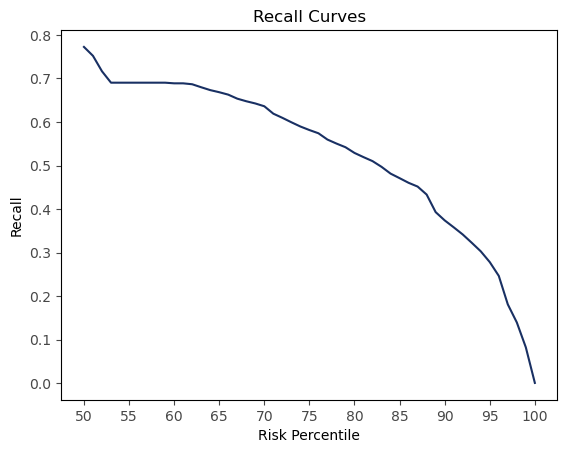

In [11]:
payout_col = 'future_two_years.lawsuits.officer_payout'

recalls = [ (100*q,calc_recall(df_lawsuits, 'phat',payout_col,q,indicator=False)) for q in np.linspace(.5,1,51)]
lawsuit_recall_df = pd.DataFrame(recalls,columns=['Risk Percentile','Recall'])
lawsuit_recall_df['Outcome'] = 'Lawsuit amount'

with plt.rc_context({
                     'xtick.color': '.28',
                     'ytick.color': '.28',
                     'axes.grid.axis': 'y',
                     'xtick.bottom': True,
                    }):
    figure = plt.figure()
    figure = sns.lineplot(x='Risk Percentile',y='Recall',data=lawsuit_recall_df,markers=True)
    plt.title("Recall Curves")
    plt.xticks([int(x) for x in np.linspace(50,100,11)])
    plt.show()


# C3: Comparison of machine learning and simple models

# Evaluating on predicting sustained complaints

In [12]:
all_results = []
recall, true_positives = calc_recall_and_num_true_positives_rbc(df_sus_complaints,rbc_col, complaint_outcome,.95)

results = {
    'method':'rank by complaints',
    'outcome':'sustained complaints',
    'recall':recall,
    'true_positives':true_positives
}
all_results.append(results)

recall, true_positives = calc_recall_and_num_true_positives_rbc(df_sus_complaints,rbl_col, complaint_outcome,.95)
results = {
    'method':'rank by lawsuits',
    'outcome':'sustained complaints',
    'recall':recall,
    'true_positives':true_positives
}
all_results.append(results)


recall = calc_recall(df_sus_complaints, 'phat',complaint_outcome,.95)
true_positives = calc_num_true_postives(df_sus_complaints, 'phat',complaint_outcome,.95)

results = {
    'method':'machine learning',
    'outcome':'sustained complaints',
    'recall':recall,
    'true_positives':true_positives
}
all_results.append(results)

pd.DataFrame(all_results)

,method,outcome,recall,true_positives
0,rank by complaints,sustained complaints,0.176498,193.00
1,rank by lawsuits,sustained complaints,0.112130,120.04
2,machine learning,sustained complaints,0.185405,202.80


## Evaluating on predicting expensive lawsuits

In [13]:
all_results = []
recall, true_positives = calc_recall_and_num_true_positives_rbc(df_lawsuits,rbc_col, lawsuit_outcome,.95)

results = {
    'method':'rank by complaints',
    'outcome':'expensive lawsuits',
    'recall':recall,
    'true_positives':true_positives
}
all_results.append(results)

recall, true_positives = calc_recall_and_num_true_positives_rbc(df_lawsuits,rbl_col, lawsuit_outcome,.95)
results = {
    'method':'rank by lawsuits',
    'outcome':'expensive lawsuits',
    'recall':recall,
    'true_positives':true_positives
}
all_results.append(results)


recall = calc_recall(df_lawsuits, 'phat',lawsuit_outcome,.95)
true_positives = calc_num_true_postives(df_lawsuits, 'phat',lawsuit_outcome,.95)

results = {
    'method':'machine learning',
    'outcome':'expensive lawsuits',
    'recall':recall,
    'true_positives':true_positives
}
all_results.append(results)

pd.DataFrame(all_results)

,method,outcome,recall,true_positives
0,rank by complaints,expensive lawsuits,0.218382,149.96
1,rank by lawsuits,expensive lawsuits,0.203485,138.16
2,machine learning,expensive lawsuits,0.272327,185.00


# C4: Predictive value of non-sustained complaints

### Drop in accuracy when predicting future sustained complaints

In [14]:
threshold = .95
all_results = []

all_complaints_col = 'phat__only_complaints'
recall = calc_recall(df_sus_complaints, all_complaints_col,complaint_outcome,threshold)
true_positives = calc_num_true_postives(df_sus_complaints, all_complaints_col,complaint_outcome,threshold)

results = {
    'method':'Model with all prior complaints',
    'outcome':'sustained complaints',
    'recall':recall,
    'true_positives':true_positives
}
all_results.append(results)


sus_complaint_col = 'phat__only_sus_complaints'
recall = calc_recall(df_sus_complaints, sus_complaint_col,complaint_outcome,threshold)
true_positives = calc_num_true_postives(df_sus_complaints, sus_complaint_col,complaint_outcome,threshold)

results = {
    'method':'Model with only sustained complaints',
    'outcome':'sustained complaints',
    'recall':recall,
    'true_positives':true_positives
}
all_results.append(results)

pd.DataFrame(all_results)

,method,outcome,recall,true_positives
0,Model with all prior complaints,sustained complaints,0.185540,202.6
1,Model with only sustained complaints,sustained complaints,0.110553,119.0


### Drop in accuracy when predicting future expensive lawsuits

In [15]:
threshold = .95
all_results = []

all_complaints_col = 'phat__only_complaints'
recall = calc_recall(df_lawsuits, all_complaints_col,lawsuit_outcome,threshold)
true_positives = calc_num_true_postives(df_lawsuits, all_complaints_col,lawsuit_outcome,threshold)

results = {
    'method':'Model with all prior complaints',
    'outcome':'expensive lawsuits',
    'recall':recall,
    'true_positives':true_positives
}
all_results.append(results)


sus_complaint_col = 'phat__only_sus_complaints'
recall = calc_recall(df_lawsuits, sus_complaint_col,lawsuit_outcome,threshold)
true_positives = calc_num_true_postives(df_lawsuits, sus_complaint_col,lawsuit_outcome,threshold)

results = {
    'method':'Model with only sustained complaints',
    'outcome':'expensive lawsuits',
    'recall':recall,
    'true_positives':true_positives
}
all_results.append(results)

pd.DataFrame(all_results)

,method,outcome,recall,true_positives
0,Model with all prior complaints,expensive lawsuits,0.238848,164.8
1,Model with only sustained complaints,expensive lawsuits,0.146118,99.2


# B3: Focus on patterns, not events 

In [16]:
serious_col = 'past_five_years.complaints.disposition_substantiated'
frequent_col = 'past_five_years.complaints.total'

In [17]:
def get_serious_vs_frequent(df, serious_col, frequent_col, outcome_col):
    

    all_results = []
    for p in df['pred_year'].unique():
        temp = df[df_lawsuits['pred_year']==p].copy()
        temp['serious_flagged'] = temp[serious_col] >= 1
        serious_flag_rate = temp['serious_flagged'].mean()

        temp_results = {
            'pred_year':p,
            'flag_rate':serious_flag_rate,
            'serious_precision':temp[temp.serious_flagged==1][outcome_col].clip(upper=1).mean(),
            'frequent_precision':calc_precision_rbc(temp, frequent_col,outcome_col,1.0-serious_flag_rate),
            'base rate':temp[outcome_col].clip(upper=1).mean()
        }
        all_results.append(temp_results)

    all_results = pd.DataFrame(all_results)
    return all_results

### Sustained complaints



In [18]:
serious_col = 'past_five_years.complaints.disposition_substantiated'
frequent_col = 'past_five_years.complaints.total'
results = get_serious_vs_frequent(df_sus_complaints,serious_col, frequent_col, complaint_outcome)

results[['base rate','serious_precision','frequent_precision']].mean()



base rate             0.031081
serious_precision     0.074646
frequent_precision    0.107663
dtype: float64

### Lawsuits

The lawsuit data doesn't have as many years of pre-period data, so we test the effect of limiting the focal years to 2017 or later (since lawsuit data only starts in 2012 or 2013). The decision of whether to limit to 2017 or later affects the overall level of precision but the relative precision of the serious and frequent policy is the same (the frequent policy is rughly twice as accurate in both cases). 

In [19]:
serious_col = 'past_five_years.lawsuits.high_payout_suit'
frequent_col = 'past_five_years.lawsuits.total'
results = get_serious_vs_frequent(df_lawsuits,serious_col, frequent_col, lawsuit_outcome)

results[['base rate','serious_precision','frequent_precision']].mean()

base rate             0.019773
serious_precision     0.064998
frequent_precision    0.134339
dtype: float64

In [20]:
serious_col = 'past_five_years.lawsuits.high_payout_suit'
frequent_col = 'past_five_years.lawsuits.total'
results = get_serious_vs_frequent(df_lawsuits[df_lawsuits.pred_year >= 2017],serious_col, frequent_col, lawsuit_outcome)

results[['base rate','serious_precision','frequent_precision']].mean()

base rate             0.015999
serious_precision     0.040252
frequent_precision    0.081729
dtype: float64